<a href="https://colab.research.google.com/github/EvM82/Machine-Learning-25/blob/main/excercise10_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import euclidean_distances

## ΕΡΩΤΗΜΑ 1

In [6]:
df = pd.read_csv("/content/dataset.csv")
df.columns

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')

In [7]:
# a
df1 = df[["Unnamed: 0", "track_id", "artists", "album_name", "track_name"]]
df = df.drop(columns=["Unnamed: 0", "track_id", "artists", "album_name", "track_name"])

# b
df = pd.get_dummies(df, columns=["track_genre"])


## ΕΡΩΤΗΜΑ 2

Κανονικοποιηση γίνεται στις μεταβλητές numeric, άρα πρώτα εντοπίζονται οι numeric και μετα σε αυτές γίνεται κανονικοποίηση min-max.

In [8]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


ΕΡΩΤΗΜΑ 3

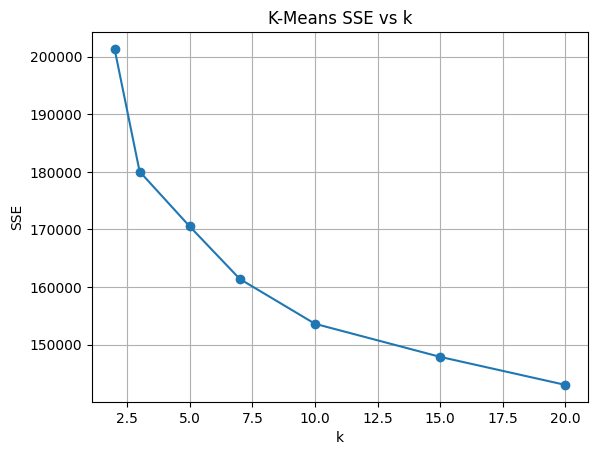

In [9]:
k_values = [2, 3, 5, 7, 10, 15, 20]
sse = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(df)
    sse.append(km.inertia_)

plt.plot(k_values, sse, marker='o')
plt.xlabel("k")
plt.ylabel("SSE")
plt.title("K-Means SSE vs k")
plt.grid(True)
plt.show()


## ΕΡΩΤΗΜΑ 4

Από το γράφημα παραπάνω και με το elbow method φαίνεται ότι καλύτερο κ είναι το 6.

In [10]:
best_k = 6

km = KMeans(n_clusters=best_k, random_state=42)
km.fit(df)

labels = km.labels_
df["cluster"] = labels
df["cluster"].value_counts()

,count
cluster,
2,34204
4,23820
0,19625
1,18316
5,9730
3,8305


## ΕΡΩΤΗΜΑ 5

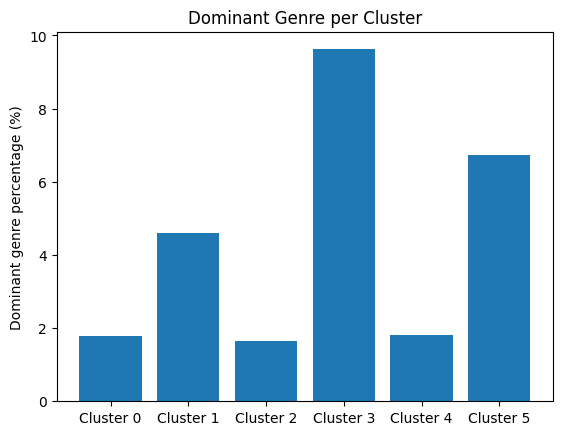

In [11]:
genre_cols = [c for c in df.columns if c.startswith("track_genre_")]

clusters = []
percents = []

for k in sorted(df['cluster'].unique()):
    cluster_k = df[df['cluster'] == k]
    dominant_label = cluster_k[genre_cols].sum().idxmax()
    percent = cluster_k[genre_cols].sum().max() / len(cluster_k) * 100

    clusters.append(f"Cluster {k}")
    percents.append(percent)

plt.bar(clusters, percents)
plt.ylabel("Dominant genre percentage (%)")
plt.title("Dominant Genre per Cluster")
plt.show()


## ΕΡΩΤΗΜΑ 6

Παρακάτω γίνεται εύρεση του cluster στο οποίο ανήκει το κομμάτι και επιλέγονται τ ακομμάτια που ανήκουν στο ίδοο cluster. Τε΄λςο υολογίζονται οι αποστλάσεις

In [12]:
#df1["track_name"].to_string()

In [15]:
selected_track_name = "Bad Liar"
selected_artist = "Imagine Dragons"

selected_idx = df1[(df1["track_name"] == selected_track_name) &(df1["artists"].str.contains(selected_artist, case=False))].index[0]

# σε ποιο cluster ανήκει
selected_cluster = labels[selected_idx]

# επιλογή των τραγουδιών που ανήκουν στο ίδιο cluster
cluster_indices = np.where(labels == selected_cluster)[0]

df_cluster = df.iloc[cluster_indices]
df1_cluster = df1.iloc[cluster_indices]

# Ευκλείδειες αποστάσεις
selected_vector = df.iloc[selected_idx].values.reshape(1, -1)
distances = euclidean_distances(selected_vector, df_cluster.values)[0]


Γίνεται αφαίρεση του επιλεγμένου τραγουδιού ώστε να μην επαναληφθεί


In [16]:
self_pos = list(cluster_indices).index(selected_idx)
distances[self_pos] = np.inf


In [17]:
#  top 3
top3_pos = np.argsort(distances)[:3]
top3_idx = cluster_indices[top3_pos]
print("\nTop-3 παρόμοια τραγούδια:\n")

for i, idx in enumerate(top3_idx, start=1):
    print(f"{i}. {df1.loc[idx, 'track_name']}")
    print(f"   Artist: {df1.loc[idx, 'artists']}")
    print(f"   Album: {df1.loc[idx, 'album_name']}")
    print(f"   Distance: {distances[top3_pos[i-1]]:.4f}\n")


Top-3 παρόμοια τραγούδια:

1. Separate Ways (Worlds Apart) - Bryce Miller/Alloy Tracks Remix
   Artist: Journey;Steve Perry
   Album: Separate Ways (Worlds Apart) [Bryce Miller/Alloy Tracks Remix]
   Distance: 0.3333

2. Thunderstruck
   Artist: AC/DC
   Album: The Razors Edge
   Distance: 0.4278

3. THE LONELIEST
   Artist: Måneskin
   Album: THE LONELIEST
   Distance: 0.4328



Τα κομμάτια ταιριάζουν ως έναν βαθμό, οχι απόλυτα αλλά υπάρχουν κοινά στοιχεία μεταξύ τους.